In [77]:
import os
import pickle 
import glob
from tqdm import tqdm
import statistics 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

with open('../../data/Hazumi_features/Hazumi1911_features_small.pkl', mode='rb') as f:
    SS, TS, SP, TP, text, audio, visual, vid = pickle.load(f, encoding='utf-8')

def get_personality(filename):
    """
    アノテータの質問回答から性格特性スコアを算出
    """
    filepath = "../../data/Hazumi/Hazumi1911/questionnaire/1911questionnaires.xlsx"
    df = pd.read_excel(filepath, sheet_name=4, header=1, index_col=0)
    data = df.loc[filename].values.tolist()
    return [data[0] + (8 - data[5]), (8-data[1]) + data[6], data[2] + (8-data[7]), data[3] + (8-data[8]), data[4] + (8-data[9])]

def get_third_personality(filename):
    """
    アノテータの質問回答から性格特性スコアを算出
    """
    file_path = '../../data/Hazumi/Hazumi1911/questionnaire/220818thirdbigfive-Hazumi1911.xlsx'
    df = pd.read_excel(file_path, sheet_name=5, header=1, index_col=0)
    data = df.loc[filename].values.tolist()
    return [data[5], data[13], data[21], data[29], data[37]]

dumpfile_path = f'../../data/Hazumi/Hazumi1911/dumpfiles/*'
files = glob.glob(dumpfile_path)

SS = {}
TS = {}
SP = {}
TP = {}
vid = []

for file_path in tqdm(sorted(files)):
    filename = os.path.basename(file_path).split('.', 1)[0]
    df = pd.read_csv(file_path)
    start = df['start(exchange)[ms]'].values.tolist()

    vid.append(filename)

    SP[filename] = get_personality(filename)
    TP[filename] = get_third_personality(filename)

    # row
    SS[filename] = df.loc[:, 'SS'].astype(int).values.tolist()
    TS[filename] = df.loc[:, 'TS1':'TS5'].mean(axis='columns').values.tolist()
    # binary
    # SS[filename] = (df.loc[:, 'SS'] >= 4.0).astype(int).values.tolist()
    # TS[filename] = (df.loc[:, 'TS1':'TS5'].mean(axis='columns') >= 4.0).astype(int).values.tolist()
    # ternary
    # SS[filename] = df.loc[:, 'SS_ternary'].astype(int).values.tolist()
    # TS[filename] = df.loc[:, 'TS_ternary'].astype(int).values.tolist()


100%|██████████| 26/26 [00:02<00:00, 10.46it/s]


In [64]:
# 本人心象と第三者心象の相関関係
Corr = []
for id in vid:
    if int(id[5]) < 6 or id[4] != "F":
        continue
    ss = SS[id]
    ts = TS[id]
    time = list(range(len(ss)))
    res = calc_corr(ss, ts)
    Corr.append(res)
    # plt.figure(figsize=(12,4))
    # plt.plot(time, ss, marker="o", label="本人心象")
    # plt.plot(time, ts, marker="o", label="第三者心象")
    # plt.title(f"uid: {id}, 相関係数： {res}")
    # plt.xlabel("time(単位：交換)")
    # plt.ylabel("心象値")
    # plt.ylim(1, 7)
    # plt.legend()
    # plt.show()

print(f"人数： {len(Corr)}")
print(f"マクロ平均： {round(statistics.mean(Corr), 3)}")
print(f"最大値： {max(Corr)}, 最小値： {min(Corr)}")

人数： 4
マクロ平均： 0.41
最大値： 0.515, 最小値： 0.258


In [116]:
A = []
for id in vid:
    p = TP[id]
    A.append(p[1])
print("協調性の中央値：", statistics.median(A))

High, Low = [], []
for id in vid:
    ss = SS[id]
    ts = TS[id]
    p = TP[id]
    corr_s, _ = stats.pearsonr(ss, ts)
    corr_s = round(corr_s, 2)
    if p[1] >= 11.8:
        High.append(corr_s)
    else:
        Low.append(corr_s)

print("High")
print(f"平均： {round(statistics.mean(High), 2)}, 標準偏差： {round(statistics.pstdev(High), 2)}")
print("Low")
print(f"平均： {round(statistics.mean(Low), 2)}, 標準偏差： {round(statistics.pstdev(Low), 2)}")

協調性の中央値： 11.8
High
平均： 0.46, 標準偏差： 0.19
Low
平均： 0.36, 標準偏差： 0.13


In [107]:
# 「本人心象と第三者心象の相関関係」と「性格特性値」の相関関係
Corr = []
E, A, C, N, O = [], [], [], [], []
for id in vid:
    if int(id[5]) < 6:
        continue
    ss = SS[id]
    ts = TS[id]
    p = TP[id]
    corr_s, _ = stats.pearsonr(ss, ts)
    Corr.append(round(corr_s, 3))
    E.append(p[0])
    A.append(p[1])
    C.append(p[2])
    N.append(p[3])
    O.append(p[4])
    # time = list(range(len(ss)))
    # plt.figure(figsize=(12,4))
    # plt.plot(time, ss, marker="o", label="本人心象")
    # plt.plot(time, ts, marker="o", label="第三者心象")
    # plt.title(f"uid: {id}, 相関係数： {res}")
    # plt.xlabel("time(単位：交換)")
    # plt.ylabel("心象値")
    # plt.ylim(1, 7)
    # plt.legend()
    # plt.show()

print(f"人数： {len(E)}")
print(f"外向性： {stats.pearsonr(E, Corr)}")
print(f"協調性： {stats.pearsonr(A, Corr)}")
print(f"勤勉性： {stats.pearsonr(C, Corr)}")
print(f"神経症傾向： {stats.pearsonr(N, Corr)}")
print(f"開放性： {stats.pearsonr(O, Corr)}")

人数： 9
外向性： PearsonRResult(statistic=-0.1932863479056218, pvalue=0.6182940357185644)
協調性： PearsonRResult(statistic=0.5823105888847961, pvalue=0.09992402843432895)
勤勉性： PearsonRResult(statistic=-0.09449495399452978, pvalue=0.8089231451050499)
神経症傾向： PearsonRResult(statistic=0.01817444711638927, pvalue=0.9629855102174609)
開放性： PearsonRResult(statistic=-0.15315504685970435, pvalue=0.6940296832011258)


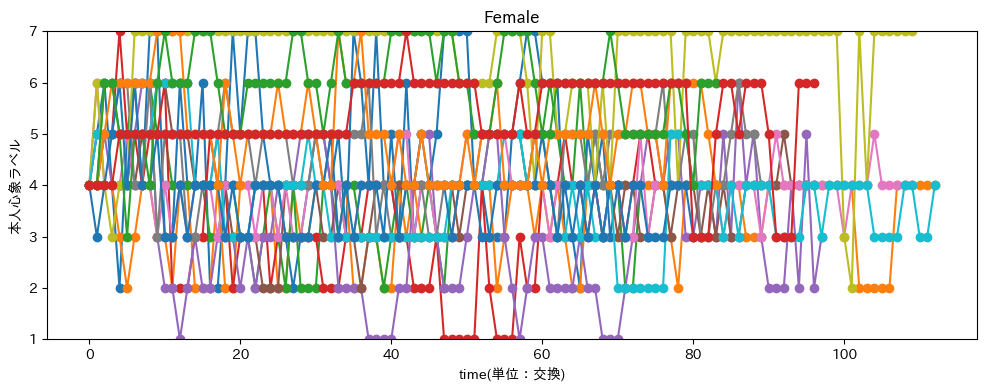

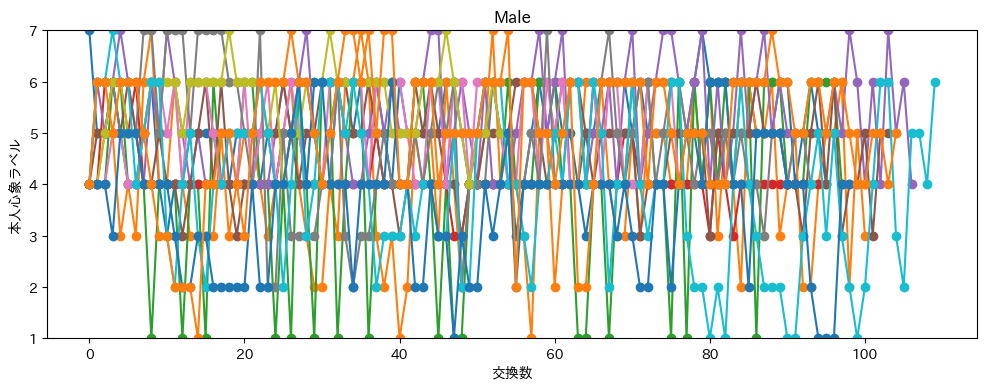

Female:  [4.662, 3.416, 3.932, 3.26, 3.143, 3.825, 3.927, 4.511, 6.491, 3.77, 3.79, 5.107, 5.881, 5.32]
平均：4.36, 標準偏差：0.977
Male:  [5.125, 4.158, 4.112, 4.126, 5.262, 4.76, 5.091, 4.851, 5.611, 4.036, 3.616, 5.095]
平均：4.654, 標準偏差：0.593


In [4]:
"""
性別ごとのグラフの分布
""" 

# 女性
plt.figure(figsize=(12,4))
female = []
for id, ss in SS.items():
    if id[4] == 'F':
        time = list(range(len(ss)))
        plt.plot(time, ss, marker="o")
        plt.title(f"Female")
        plt.xlabel("time(単位：交換)")
        plt.ylabel("本人心象ラベル")
        plt.ylim(1, 7)
        ave = round(statistics.mean(ss), 3)
        female.append(ave)

plt.show()

#　男性
plt.figure(figsize=(12,4))
male = []
for id, ss in SS.items():
    if id[4] == 'M':
        time = list(range(len(ss)))
        plt.plot(time, ss, marker="o")
        plt.title(f"Male")
        plt.xlabel("交換数")
        plt.ylabel("本人心象ラベル")
        plt.ylim(1, 7)
        ave = round(statistics.mean(ss), 3)
        male.append(ave)
plt.show()

print("Female: ", female)
print(f"平均：{round(statistics.mean(female), 3)}, 標準偏差：{round(statistics.pstdev(female), 3)}")
print("Male: ", male)
print(f"平均：{round(statistics.mean(male), 3)}, 標準偏差：{round(statistics.pstdev(male), 3)}")

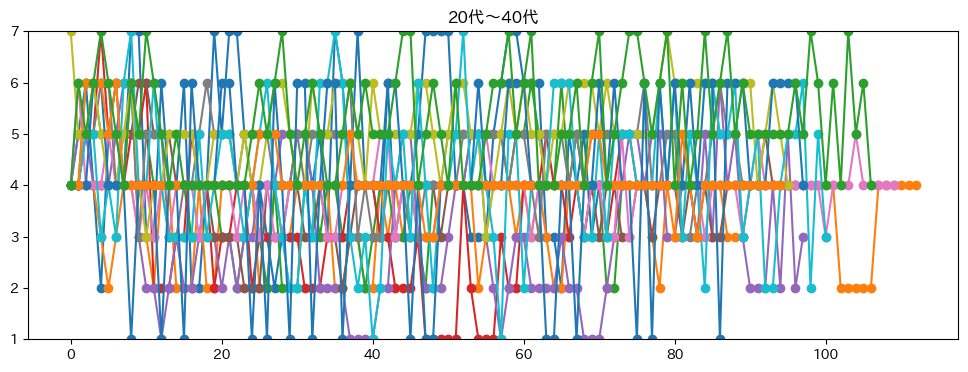

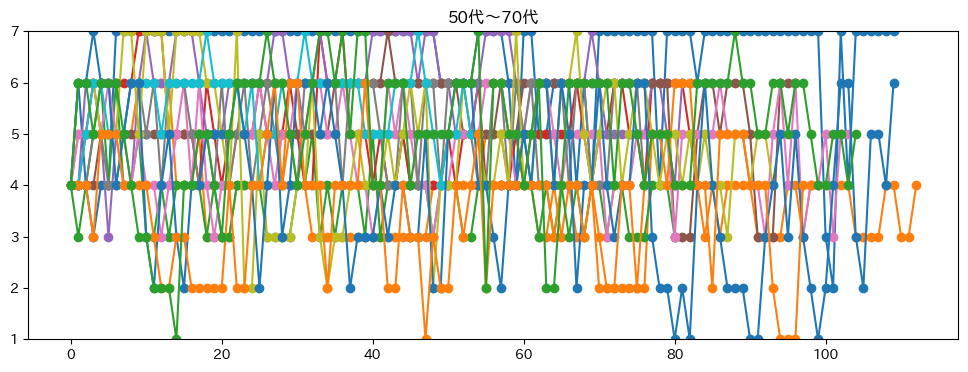

Female:  [4.662, 3.416, 3.932, 3.26, 3.143, 3.825, 3.927, 4.511, 6.491, 3.77, 3.79, 5.107, 5.881, 5.32]
平均：4.36, 標準偏差：0.977
Male:  [5.125, 4.158, 4.112, 4.126, 5.262, 4.76, 5.091, 4.851, 5.611, 4.036, 3.616, 5.095]
平均：4.654, 標準偏差：0.593


In [5]:
"""
年齢ごとのグラフの分布
""" 

# 20代~40代
plt.figure(figsize=(12,4))
young = []
for id, ss in SS.items():
    if int(id[5]) <= 4:
        time = list(range(len(ss)))
        plt.plot(time, ss, marker="o")
        plt.title(f"20代〜40代")
        plt.ylim(1, 7)
plt.show()

#　50代~70代
plt.figure(figsize=(12,4))
elder = []
for id, ss in SS.items():
    if int(id[5]) >= 5:
        time = list(range(len(ss)))
        plt.plot(time, ss, marker="o")
        plt.title(f"50代〜70代")
        plt.ylim(1, 7)
plt.show()

print("Female: ", female)
print(f"平均：{round(statistics.mean(female), 3)}, 標準偏差：{round(statistics.pstdev(female), 3)}")
print("Male: ", male)
print(f"平均：{round(statistics.mean(male), 3)}, 標準偏差：{round(statistics.pstdev(male), 3)}")